# Local Climate Zone (LCZ) Identification Model - All Bands

This set of notebooks (2a and 2b) focuses on the fitting of the LCZ Identification Model using 2 different sets of specifications:
1. RGB Bands SENTINEL-2 images
2. All Bands (10) SENTINEL-2 images

In [34]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, layers, models, losses, Model, optimizers, metrics

# additional configuration for function decorator, as TF2.0 does not have this set as True by default
# this is required for the model to fit
tf.config.run_functions_eagerly(True)

In [36]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


----

## Import Dataset

In [37]:
# load dataset - specify split if need to split into train and validation
train_ds, val_ds = tfds.load('so2sat/all', split=['train','validation'], download=False)

In [38]:
train_ds

<_PrefetchDataset element_spec={'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sample_id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'sentinel1': TensorSpec(shape=(32, 32, 8), dtype=tf.float32, name=None), 'sentinel2': TensorSpec(shape=(32, 32, 10), dtype=tf.float32, name=None)}>

In [39]:
# Function to remove sentinel 1 data from tf dataset
def remove_sen1_from_tfds(ds):
    
    ds = ds.map(lambda x: {'label': x['label'],
                           'sample_id': x['sample_id'],
                           'sentinel2': x['sentinel2']})
    return ds

In [40]:
# Function to convert a tf dataset into a supervised format
def convert_to_supervised_tfds(ds, predictor, outcome='label'):
    '''
    Parameters:
    -----------
    ds: tfds dataset
    
    predictor: str
        name of predictor variable
        
    outcome: str
        name of outcome variable
        
    Returns:
    --------
    tfds dataset
        tuple with predictor and then outcome
    '''
    ds = ds.map(lambda x: (x[predictor], x[outcome]))
    
    return ds

In [41]:
# Function to reverse the order of the first 3 bands, i.e. BGR to RGB
def remove_sen1_and_reverse_bgr(ds):
    
    ds = ds.map(lambda x: {'label': x['label'],
                          'sample_id': x['sample_id'],
                          'sentinel2': tf.gather(params=x['sentinel2'], 
                                                 indices=[2, 1, 0, 3, 4, 5, 6, 7, 8, 9],
                                                 axis=2)})
    
    return ds

In [42]:
# remove sentinel 1 data from train and val datasets
train_ds = remove_sen1_and_reverse_bgr(train_ds)
val_ds = remove_sen1_and_reverse_bgr(val_ds)

In [43]:
# convert so2sat dataset into supervised, with sentinel2 data as predictor
train_ds = convert_to_supervised_tfds(train_ds, 'sentinel2')
val_ds = convert_to_supervised_tfds(val_ds, 'sentinel2')

In [44]:
# convert normalised reflectance values to 255 shades to be more compatible with resnet50 pretrained model
train_ds = train_ds.map(lambda image, label: ((image*255), label))
val_ds = val_ds.map(lambda image, label: ((image*255), label))

2023-05-26 00:46:28.487908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [256]
	 [[{{node Placeholder/_3}}]]
2023-05-26 00:46:28.488446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [256]
	 [[{{node Placeholder/_2}}]]


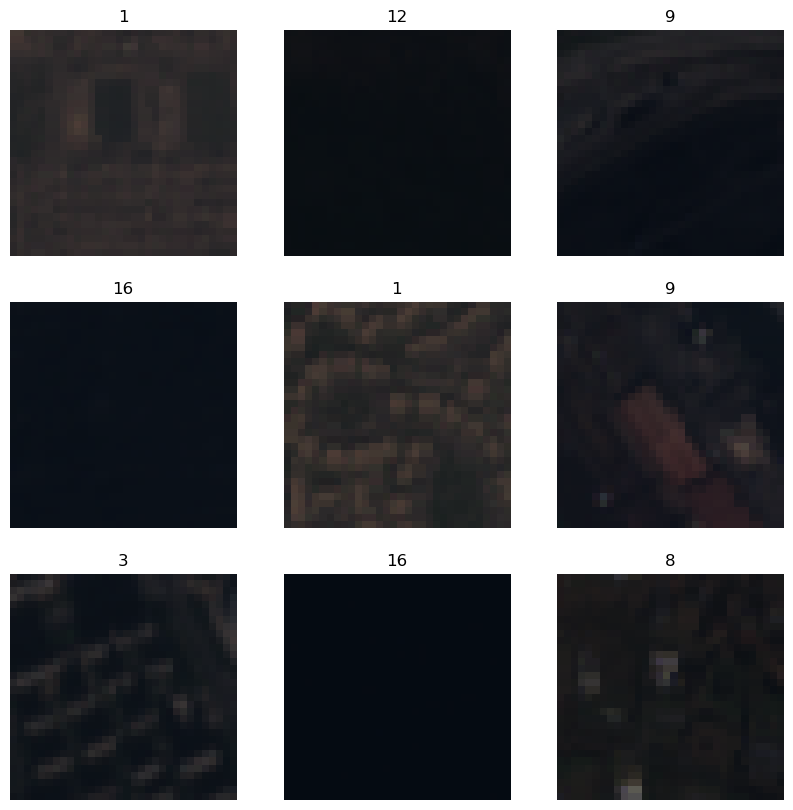

In [45]:
# check out the first 9 images of the training dataset (for fun)
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9).as_numpy_iterator()):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[:,:,:3].astype(int))
    plt.title(int(label))
    plt.axis("off")


----

## Import Pretrained ResNet50 Model

In [13]:
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (32,32,3))

base_model.trainable= False

### Reconfigure ResNet50 for RGB Band LCZ Identification Model

ResNet50 is pretrained on 3-channel images. In order to handle an input of 10 channels, we need to expand the input channel to 10 channels. More details here: https://towardsdatascience.com/implementing-transfer-learning-from-rgb-to-multi-channel-imagery-f87924679166

In [14]:
# Get Resnet config in dictionary format
config = base_model.get_config()

# Change input shape to new dimensions
config["layers"][0]["config"]["batch_input_shape"] = (None, 32, 32, 10)

In [15]:
# create new base_model with new config
base_model_new = tf.keras.models.Model.from_config(config)

In [16]:
def multify_weights(kernel, out_channels):
    '''
    Function to expand weights dimension to match new input channels
    '''
    mean_1d = np.mean(kernel, axis=-2).reshape(kernel[:,:,-1:,:].shape)
    
    tiled = np.tile(mean_1d, (out_channels, 1))
    
    return(tiled)

In [17]:
def copy_weights_tl(model_orig, custom_model, layer_modify):
    '''
    Function that loops through layers to both original and new model to copy over weights,
    only first convolutional layer will have new weights
    '''
    layer_to_modify = [layer_modify]

    conf = custom_model.get_config()
    layer_names = [conf['layers'][x]['name'] for x in range(len(conf['layers']))]

    for layer in model_orig.layers:
        if layer.name in layer_names:
            if layer.get_weights() != []:
                target_layer = custom_model.get_layer(layer.name)

                if layer.name in layer_to_modify:    
                    kernels = layer.get_weights()[0]
                    biases  = layer.get_weights()[1]

                    kernels_extra_channel = np.concatenate((kernels,
                                                          multify_weights(kernels, 10 - 3)),
                                                          axis=-2)

                    target_layer.set_weights([kernels_extra_channel, biases])
                    target_layer.trainable = True

                else:
                    target_layer.set_weights(layer.get_weights())
                    target_layer.trainable = False

In [18]:
copy_weights_tl(base_model, base_model_new, 'conv1_conv')

In [19]:
# create new model on top
inputs = tf.keras.Input(shape=(32, 32, 10))
#inputs = layers.Conv2D(3, (1,1), activation='relu')(inputs)

In [20]:
# build full model
x = base_model_new(inputs)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dense(1000, activation='relu')(x)
x = layers.Dropout(0.2)(x)
predictions = layers.Dense(17, activation='softmax')(x)

model_resnet50 = Model(inputs=inputs, outputs=predictions)

In [49]:
# define batch size and caching to optimise training speed
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
val_ds = val_ds.cache().batch(batch_size).prefetch(buffer_size=10)


In [22]:
model_resnet50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 10)]      0         
                                                                 
 resnet50 (Functional)       (None, 1, 1, 2048)        23609664  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 17)                34833     
                                                                 
Total params: 23,644,497
Trainable params: 66,257
Non-trainable params: 23,578,240
____________________________________________

In [23]:
# implement early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)


In [24]:
# implement Tensorboard history logging
history_logger = tf.keras.callbacks.TensorBoard(log_dir='../models/resnet50_10ch/')

## to use tensorboard
# tensorboard --logdir=path_to_your_logs

In [25]:
# compile model
model_resnet50.compile(
    optimizer=optimizers.Adam(),
    loss=losses.sparse_categorical_crossentropy,
    metrics=[metrics.sparse_categorical_accuracy],
)

### Compile and Fit Model

The model fitting is split into multiple steps to both enable interim checks on model performance and safeguards in case the kernel dies halfway

In [26]:
history_resnet50 =  model_resnet50.fit(train_ds, epochs=5, 
                                       validation_data=val_ds, 
                                       #batch_size=32,
                                       callbacks=[callback, history_logger],
                                       workers=3, use_multiprocessing=True)

Epoch 1/5


2023-05-21 07:36:48.444969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [256]
	 [[{{node Placeholder/_4}}]]
2023-05-21 07:36:48.445389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [256]
	 [[{{node Placeholder/_0}}]]


11012/11012 [==============================] - ETA: 0s - loss: 1.0678 - sparse_categorical_accuracy: 0.6497

2023-05-21 09:04:29.601171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [16]
	 [[{{node Placeholder/_3}}]]
2023-05-21 09:04:29.601680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16]
	 [[{{node Placeholder/_0}}]]


11012/11012 [==============================] - 5387s 489ms/step - loss: 1.0678 - sparse_categorical_accuracy: 0.6497 - val_loss: 1.6302 - val_sparse_categorical_accuracy: 0.5275
Epoch 2/5
11012/11012 [==============================] - 4081s 371ms/step - loss: 0.9300 - sparse_categorical_accuracy: 0.6904 - val_loss: 1.6225 - val_sparse_categorical_accuracy: 0.5371
Epoch 3/5
11012/11012 [==============================] - 3981s 362ms/step - loss: 0.8897 - sparse_categorical_accuracy: 0.7037 - val_loss: 1.7861 - val_sparse_categorical_accuracy: 0.5443
Epoch 4/5
11012/11012 [==============================] - 3901s 354ms/step - loss: 0.8660 - sparse_categorical_accuracy: 0.7107 - val_loss: 1.6119 - val_sparse_categorical_accuracy: 0.5398
Epoch 5/5
11012/11012 [==============================] - 3938s 358ms/step - loss: 0.8511 - sparse_categorical_accuracy: 0.7159 - val_loss: 1.6772 - val_sparse_categorical_accuracy: 0.5409


In [27]:
# save model
model_resnet50.save('../models/model_resnet50_10ch_trans_rev')

INFO:tensorflow:Assets written to: ../models/model_resnet50_10ch_trans_rev/assets


INFO:tensorflow:Assets written to: ../models/model_resnet50_10ch_trans_rev/assets


In [28]:
# save history
import json

json.dump(history_resnet50.history, open('../models/history_resnet50_10ch_trans_rev.json', 'w'))

In [29]:
history_resnet50 =  model_resnet50.fit(train_ds, epochs=20, 
                                       validation_data=val_ds, 
                                       #batch_size=32,
                                       callbacks=[callback, history_logger],
                                      initial_epoch=history_resnet50.epoch[-1]+1,
                                       workers=4, use_multiprocessing=True)

Epoch 6/20
11012/11012 [==============================] - 4558s 414ms/step - loss: 0.8381 - sparse_categorical_accuracy: 0.7193 - val_loss: 2.0210 - val_sparse_categorical_accuracy: 0.5225
Epoch 7/20
11012/11012 [==============================] - 4736s 430ms/step - loss: 0.8274 - sparse_categorical_accuracy: 0.7229 - val_loss: 1.8935 - val_sparse_categorical_accuracy: 0.5325
Epoch 8/20
11012/11012 [==============================] - 4743s 431ms/step - loss: 0.8186 - sparse_categorical_accuracy: 0.7256 - val_loss: 1.9285 - val_sparse_categorical_accuracy: 0.5331
Epoch 9/20
11012/11012 [==============================] - 4627s 420ms/step - loss: 0.8085 - sparse_categorical_accuracy: 0.7290 - val_loss: 2.0970 - val_sparse_categorical_accuracy: 0.5419
Epoch 10/20
11012/11012 [==============================] - 4562s 414ms/step - loss: 0.8036 - sparse_categorical_accuracy: 0.7304 - val_loss: 2.2534 - val_sparse_categorical_accuracy: 0.5258
Epoch 11/20
11012/11012 [=============================

In [30]:
# save model
model_resnet50.save('../models/model_resnet50_10ch_trans_rev_2')

INFO:tensorflow:Assets written to: ../models/model_resnet50_10ch_trans_rev_2/assets


INFO:tensorflow:Assets written to: ../models/model_resnet50_10ch_trans_rev_2/assets


In [31]:
# save history
import json

json.dump(history_resnet50.history, open('../models/history_resnet50_10ch_trans_rev_2.json', 'w'))

In [31]:
history_resnet50 =  model_resnet50.fit(train_ds, epochs=30, 
                                       validation_data=val_ds, 
                                       #batch_size=32,
                                       callbacks=[callback, history_logger],
                                       initial_epoch=history_resnet50.epoch[-1]+1,
                                       workers=4, use_multiprocessing=True)

Epoch 21/30
11012/11012 [==============================] - 3857s 350ms/step - loss: 0.7587 - sparse_categorical_accuracy: 0.7451 - val_loss: 2.1856 - val_sparse_categorical_accuracy: 0.5502
Epoch 22/30
11012/11012 [==============================] - 3884s 353ms/step - loss: 0.7582 - sparse_categorical_accuracy: 0.7460 - val_loss: 2.1639 - val_sparse_categorical_accuracy: 0.5397
Epoch 23/30
11012/11012 [==============================] - 3924s 356ms/step - loss: 0.7542 - sparse_categorical_accuracy: 0.7474 - val_loss: 2.2999 - val_sparse_categorical_accuracy: 0.5496
Epoch 24/30
11012/11012 [==============================] - 3964s 360ms/step - loss: 0.7547 - sparse_categorical_accuracy: 0.7473 - val_loss: 2.1809 - val_sparse_categorical_accuracy: 0.5476
Epoch 25/30
11012/11012 [==============================] - 3938s 358ms/step - loss: 0.7511 - sparse_categorical_accuracy: 0.7485 - val_loss: 2.5529 - val_sparse_categorical_accuracy: 0.5380
Epoch 26/30
11012/11012 [=========================

In [32]:
# save model
model_resnet50.save('../models/model_resnet50_10ch_trans_rev_3')

INFO:tensorflow:Assets written to: ../models/model_resnet50_10ch_trans_rev_3/assets


INFO:tensorflow:Assets written to: ../models/model_resnet50_10ch_trans_rev_3/assets


In [33]:
# save history
import json

json.dump(history_resnet50.history, open('../models/history_resnet50_10ch_trans_rev_3.json', 'w'))

In [50]:
history_resnet50 =  model_resnet50.fit(train_ds, epochs=50, 
                                       validation_data=val_ds, 
                                       #batch_size=32,
                                       callbacks=[callback, history_logger],
                                      initial_epoch=history_resnet50.epoch[-1]+1,
                                       workers=4, use_multiprocessing=True)

Epoch 31/50


2023-05-26 08:17:46.808022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype int64 and shape [256]
	 [[{{node Placeholder/_3}}]]
2023-05-26 08:17:46.808495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [256]
	 [[{{node Placeholder/_4}}]]


11012/11012 [==============================] - ETA: 0s - loss: 0.7407 - sparse_categorical_accuracy: 0.7523

2023-05-26 09:22:28.118689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [16]
	 [[{{node Placeholder/_2}}]]
2023-05-26 09:22:28.119170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int64 and shape [16]
	 [[{{node Placeholder/_4}}]]


11012/11012 [==============================] - 4000s 363ms/step - loss: 0.7407 - sparse_categorical_accuracy: 0.7523 - val_loss: 2.3611 - val_sparse_categorical_accuracy: 0.5453
Epoch 32/50
11012/11012 [==============================] - 4008s 364ms/step - loss: 0.7429 - sparse_categorical_accuracy: 0.7515 - val_loss: 2.5747 - val_sparse_categorical_accuracy: 0.5508
Epoch 33/50
11012/11012 [==============================] - 4078s 370ms/step - loss: 0.7387 - sparse_categorical_accuracy: 0.7529 - val_loss: 2.2740 - val_sparse_categorical_accuracy: 0.5417
Epoch 34/50
11012/11012 [==============================] - 4074s 370ms/step - loss: 0.7377 - sparse_categorical_accuracy: 0.7532 - val_loss: 2.4218 - val_sparse_categorical_accuracy: 0.5531
Epoch 35/50
11012/11012 [==============================] - 4070s 370ms/step - loss: 0.7349 - sparse_categorical_accuracy: 0.7541 - val_loss: 2.4788 - val_sparse_categorical_accuracy: 0.5412
Epoch 36/50
11012/11012 [==============================] - 404

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



11012/11012 [==============================] - 3997s 363ms/step - loss: 0.7335 - sparse_categorical_accuracy: 0.7551 - val_loss: 2.5607 - val_sparse_categorical_accuracy: 0.5470


In [51]:
# save model
model_resnet50.save('../models/model_resnet50_10ch_trans_rev_4')

INFO:tensorflow:Assets written to: ../models/model_resnet50_10ch_trans_rev_4/assets


INFO:tensorflow:Assets written to: ../models/model_resnet50_10ch_trans_rev_4/assets


In [52]:
# save history
import json

json.dump(history_resnet50.history, open('../models/history_resnet50_10ch_trans_rev_4.json', 'w'))